In [1]:
# 예제 10-1

import time
from scipy import stats


# 데이터 구조 정의
# 사용자 ID를 키로, 상품 코드의 셋을 밸류로 갖는 딕셔너리와
# 상품 코드를 키로, 사용자 ID의 셋을 밸류로 갖는 딕셔너리
user_product_dic = {}
product_user_dic = {}

# 상품 코드를 키로 가지고 상품명을 밸류로 갖는 딕셔너리
# 군집화의 내용을 확인하는 단계에서 상품명을 사용합니다.
product_id_name_dic = {}

# 파일을 읽어 위에 정의한 데이터구조를 채웁니다.
for line in open('online_retail_utf.txt'):

    # 데이터를 한 행씩 읽어서 필요한 항목을 저장합니다.
    line_items = line.strip().split('\t')
    user_code = line_items[6]
    product_id = line_items[1]
    product_name = line_items[2]

    # 사용자 ID가 없을 경우 무시합니다.
    if len(user_code) == 0:
        continue

    # 영국에서 구매한 사용자만 고려하므로, 국가가 united kingdom이 아닌 경우엔 무시합니다.
    country = line_items[7]
    if country != 'United Kingdom':
        continue

    # 연도 읽을 때 에러 처리. 파일 헤더를 무시합니다.
    try:
        invoice_year = time.strptime(line_items[4], '%m/%d/%y %H:%M').tm_year

    except ValueError:
        continue

    # 2011년에 일어난 구매가 아닌 것은 무시합니다.
    if invoice_year != 2011:
        continue

    # 읽은 정보로 데이터 구조를 채웁니다.
    # 상품 가짓수를 고려하므로 상품 코드를 셋으로 가지도록 하겠습니다.
    user_product_dic.setdefault(user_code, set())
    user_product_dic[user_code].add(product_id)

    product_user_dic.setdefault(product_id, set())
    product_user_dic[product_id].add(user_code)

    product_id_name_dic[product_id] = product_name

# 데이터구조를 다 채웠으므로 각 사용자들이 구매한 상품 가짓수로 리스트를 만들어봅시다.
product_per_user_li = [len(x) for x in user_product_dic.values()]


# 이 장에서 사용할 최종 사용자 수와 상품 가짓수를 출력해봅니다.
print('# of users:', len(user_product_dic))
print('# of products:', len(product_user_dic))

# 각 사용자들이 구매한 상품 가짓수로 기초 통계량을 출력합니다.
print(stats.describe(product_per_user_li))

# of users: 3835
# of products: 3588
DescribeResult(nobs=3835, minmax=(1, 1603), mean=58.690743155149931, variance=6207.1088214350575, skewness=5.833816723404396, kurtosis=72.60364097540136)


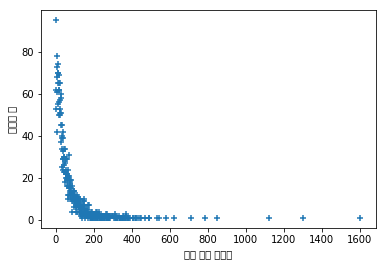

In [2]:
# 예제 10-2

from collections import Counter
import matplotlib.pyplot as plt
# 사용자가 구매한 고유 상품 가짓수를 플롯해봅니다.
plot_data_all = Counter(product_per_user_li)
plot_data_x = list(plot_data_all.keys())
plot_data_y = list(plot_data_all.values())
plt.xlabel('고유 상품 가짓수')
plt.ylabel('사용자 수')
plt.scatter(plot_data_x, plot_data_y, marker='+')
plt.show()

In [2]:
# 예제 10-3

# 구매한 상품의 가짓수가 1인 사용자의 사용자 ID를 찾습니다.
min_product_user_li =[k for k,v in user_product_dic.items() if len(v)==1]
# 마찬가지로, 구매한 상품의 가짓수가 600개 이상인 사용자의 사용자 ID를 찾습니다.
max_product_user_li =[k for k,v in user_product_dic.items() if len(v)>600]
print("# of users purchased one product:%d" % (len(min_product_user_li)))
print("# of users purchased more than 600 product:%d" % (len(max_product_user_li)))
# 찾아낸 사용자를 군집화에 사용할 user_product_dic에서 제외합니다.
user_product_dic = {k:v for k,v in user_product_dic.items() if len(v)>1 and len(v)<=600}
print("# of left user:%d" % (len(user_product_dic)))
# 남아 있는 사용자가 구매한 상품에도 0에서 시작하는 고유 ID를 부여합니다.
# 데이터셋에서 제외된 사용자가 구매한 상품은 군집화에서 사용하지 않기 때문에 이러한 처리를 해야 합니다.
id_product_dic = {}
for product_set_li in user_product_dic.values():
    for x in product_set_li:
        if x in id_product_dic:
            product_id = id_product_dic[x]
        else:
            id_product_dic.setdefault(x, len(id_product_dic))
print("# of left items:%d" % (len(id_product_dic)))

# of users purchased one product:95
# of users purchased more than 600 product:7
# of left user:3733
# of left items:3568


In [3]:
# 예제 10-4

# 사용자 ID 참조를 위한 딕셔너리
id_user_dic = {}

# 군집화의 입력으로 사용할 리스트
user_product_vec_li = []

# 군집화에서 사용할 총 고유 상품 가짓수. 즉, 원-핫 인코딩으로 변환할 피처의 가짓수
all_product_count = len(id_product_dic)

for user_code, product_per_user_set in user_product_dic.items():
    # 고유 상품 가짓수를 길이로 하는 리스트 생성
    user_product_vec = [0] * all_product_count
    # id_user_dic의 길이를 이용하여 사용자 ID를 0부터 시작하는 user_id로 바꿉니다.
    id_user_dic[len(id_user_dic)] = user_code
    
    # 사용자가 구매한 상품 코드를 키로 하여 user_product_vec에서의
    # 해당 상품 코드의 상품 ID를 찾습니다. 그리고 값을 1로 세팅합니다.
    for product_name in product_per_user_set:
        user_product_vec[id_product_dic[product_name]] = 1
    
    # 한 사용자의 처리가 끝났으므로 이 사용자의 user_product_vec을 배열에 추가합니다.
    # 이때 배열의 인덱스는 새로 정의한 user_id가 됩니다.
    user_product_vec_li.append(user_product_vec)
    
print(id_user_dic[0])
print(user_product_dic['17080'])
print(user_product_vec_li[0])
print(len(user_product_vec_li[0]))

13313
{'23328', '23103', '23393', '23407', '84978', '23491', '23398', '23399'}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# 예제 10-5

from sklearn.cluster import KMeans
import random

# 학습용과 평가용 데이터로 나누기 위해 사용자-상품 벡터를 셔플합니다.
random.shuffle(user_product_vec_li)

# 학습용 데이터에 사용자 2500명을, 평가용 데이터에 나머지 사용자를 넣습니다.
# 학습용 데이터에 있는 사용자 정보만을 가지고 클러스터를 만든 후
# 평가용 데이터의 사용자가 어느 클러스터에 속하는지 알아봅니다.
train_data = user_product_vec_li[:2500]
test_data = user_product_vec_li[2500:]

print("# of train data:% d, # of test_data: %d" % (len(train_data),len(test_data)))
# 학습 데이터를 군집화하여 4개의 클러스터를 생성한 후 그 결과를 km_predict에 저장합니다.
km_predict = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=20).fit(train_data)

# km_predict 의 predict 함수를 이용하여 평가 데이터가 전 단계에서 만든 4개의 클러스터 중 어느 곳에
# 속하는지 살펴봅니다.
km_predict_result = km_predict.predict(test_data)
print(km_predict_result)

# of train data: 2500, # of test_data: 1233
[3 1 1 ..., 3 1 1]


In [6]:
#예제 10-6

import numpy as np

from sklearn.metrics import silhouette_score
test_data = np.array(user_product_vec_li)

for k in range(2,9):
    km = KMeans(n_clusters=k).fit(test_data)
    print("score for %d clusters:%.3f" % (k, silhouette_score(test_data,km.labels_)))

score for 2 clusters:0.345
score for 3 clusters:0.331
score for 4 clusters:0.196
score for 5 clusters:0.193
score for 6 clusters:0.207
score for 7 clusters:0.157
score for 8 clusters:0.144


208524.886686
201135.189311
198964.960511
198615.493152
197896.466999
197772.327384
197177.906462


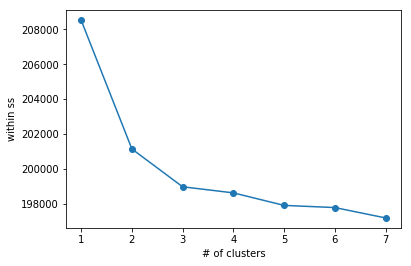

In [7]:
#예제 10-7

# 클러스터 수를 키로 하고 inertia를 값으로 하는 딕셔너리입니다.
ssw_dic={}

# 클러스터 수 K를 1부터 8까지 바꾸어가며 급내제곱합의 평균값을 계산하고,
# K를 키로 지정하여 딕셔너리에 넣습니다.
for k in range(1, 8):
    km= KMeans(n_clusters=k).fit(test_data)
    ssw_dic[k] = km.inertia_
    print(km.inertia_)

plot_data_x = list(ssw_dic.keys())
plot_data_y = list(ssw_dic.values())
plt.xlabel("# of clusters")
plt.ylabel("within ss")
plt.plot(plot_data_x, plot_data_y, linestyle="-", marker='o')
plt.show()

In [7]:
#예제 10-8

def analyze_clusters_keywords(labels,product_id_name_dic,user_product_dic, id_user_dic):
    #각 클러스터의 아이디와, 해당 아이디의 클러스터 들어있는 유저 수를 출력합니다. 
    print(Counter(labels))
    cluster_item = {}

    for i in range(len(labels)):
        cluster_item.setdefault(labels[i], [])

        # 각 사용자의 임시 ID i에 대해 사용자 코드를 찾은 후
        # 그 사용자 코드와 연결된 구매상품의 ID를 참조한 후
        # 그 ID를 이용해 상품명을 찾아
        # 딕셔너리에 클러스터 ID를 키로, 상품명을 값으로 추가합니다.
        for x in user_product_dic[id_user_dic[i]]:
            cluster_item[labels[i]].extend([product_id_name_dic[x]])
    
    for cluster_id, product_name in cluster_item.items():
        
        # 각 클러스터안의 상품명을 join명령으로 합쳐 하나의 문자열로 만든 뒤
        # 스페이스 혹은 탭으로 스플릿하여 키워드로 분해합니다. 
        product_name_keyword = (" ").join(product_name).split()

        # 클러스터의 아이디와, 그 아이디를 가지는 클러스터에 속하는 유저들이 구매한 상품들의 상품명안에
        # 가장 자주 나타나는 단어 20개를 역순으로 출력합니다
        print("cluster_id:", cluster_id)
        print(Counter(product_name_keyword).most_common(20))


In [15]:
# 예제 10-8 실행


km=KMeans(n_clusters=2, n_init=10,max_iter=20,random_state=None)
test_data=np.array(user_product_vec_li)
km.fit(test_data)
analyze_clusters_keywords(km.labels_,product_id_name_dic,user_product_dic,id_user_dic)

Counter({0: 3202, 1: 531})
cluster_id: 0
[('OF', 12237), ('SET', 12235), ('HEART', 9828), ('VINTAGE', 8551), ('RED', 8011), ('BAG', 7715), ('CHRISTMAS', 6927), ('RETROSPOT', 6610), ('DESIGN', 5846), ('PINK', 5477), ('BOX', 4819), ('CAKE', 4714), ('METAL', 4675), ('3', 4565), ('HANGING', 4294), ('WHITE', 4216), ('HOLDER', 4191), ('T-LIGHT', 3972), ('BLUE', 3932), ('PACK', 3527)]
cluster_id: 1
[('OF', 10662), ('SET', 10419), ('BAG', 8752), ('VINTAGE', 7400), ('RED', 7309), ('HEART', 7058), ('RETROSPOT', 5707), ('DESIGN', 5558), ('CHRISTMAS', 5530), ('PINK', 4736), ('BOX', 4054), ('CAKE', 3972), ('METAL', 3781), ('BLUE', 3544), ('JUMBO', 3455), ('3', 3453), ('LUNCH', 3278), ('WHITE', 3113), ('SIGN', 3080), ('PACK', 3047)]


In [16]:
# 예제 10-9

def analyze_clusters_keywords_bigram(labels,product_id_name_dic,user_product_dic, id_user_dic):
    #각 클러스터의 아이디와, 해당 아이디의 클러스터 들어있는 유저 수를 출력합니다. 
    print(Counter(labels))
    cluster_item = {}

    for i in range(len(labels)):
        cluster_item.setdefault(labels[i], [])

        # 각 사용자의 임시 ID i에 대해 사용자 코드를 찾은 후
        # 그 사용자 코드와 연결된 구매상품의 ID를 참조한 후
        # 그 ID를 이용해 상품명을 찾아
        # 딕셔너리에 클러스터 ID를 키로, 상품명을 값으로 추가합니다.
        for x in user_product_dic[id_user_dic[i]]:
            cluster_item[labels[i]].extend([product_id_name_dic[x]])

    for cluster_id, product_name in cluster_item.items():
        # 각 클러스터 안의 상품명을 join 명령으로 합쳐 하나의 문자열로 만든 뒤
        # OF를 공백으로 리플레이스하고
        # 스페이스 혹은 탭으로 스플릿하여 키워드로 분해한 뒤
        # 연속되는 두 키워드를 합쳐서 하나의 키워드를 만듭니다.
        bigram = []
        product_name_keyword = (' ').join(product_name).replace(' OF ', ' ').split()
        for i in range(0, len(product_name_keyword) - 1):
            bigram.append(' '.join(product_name_keyword[i:i + 2]))
        print('cluster_id:', cluster_id)
        print(Counter(bigram).most_common(20))

In [17]:
# 예제 10-9 실행

analyze_clusters_keywords_bigram(km.labels_,product_id_name_dic,user_product_dic,id_user_dic)

Counter({0: 3202, 1: 531})
cluster_id: 0
[('RED RETROSPOT', 3436), ('T-LIGHT HOLDER', 2909), ('JUMBO BAG', 2522), ('METAL SIGN', 2520), ('HOT WATER', 2085), ('WATER BOTTLE', 2085), ('LUNCH BAG', 2051), ('SET 3', 1899), ('VINTAGE CHRISTMAS', 1871), ('CAKE CASES', 1724), ('SET 6', 1603), ('HANGING HEART', 1364), ("50'S CHRISTMAS", 1253), ('PACK 12', 1226), ('BAG VINTAGE', 1150), ('HOME SWEET', 1141), ('SWEET HOME', 1141), ('DOLLY GIRL', 1109), ('VINTAGE DOILY', 1077), ('SET 4', 1064)]
cluster_id: 1
[('RED RETROSPOT', 3042), ('JUMBO BAG', 2892), ('LUNCH BAG', 2611), ('METAL SIGN', 2314), ('CAKE CASES', 1879), ('T-LIGHT HOLDER', 1737), ('SET 3', 1650), ('HOT WATER', 1644), ('WATER BOTTLE', 1644), ('VINTAGE CHRISTMAS', 1549), ('DOLLY GIRL', 1484), ('BAG VINTAGE', 1295), ('SET 6', 1248), ('VINTAGE DOILY', 1168), ('SET 4', 1073), ("50'S CHRISTMAS", 1041), ('PACK 12', 1010), ('PINK POLKADOT', 896), ('HOME SWEET', 896), ('SWEET HOME', 896)]


In [18]:
# 예제 10-10

def analyze_clusters_product_count(label, user_product_dic, id_user_dic):
    product_len_dic = {}
    for i in range(0, len(label)):
        product_len_dic.setdefault(label[i], [])
        # 클러스터의 ID를 키로 하는 딕셔너리에
        # 그 클러스터에 속한 사용자가 구매한 고유 상품의 가짓수를 저장합니다.
        product_len_dic[label[i]].append(len(user_product_dic[id_user_dic[i]]))
    for k, v in product_len_dic.items():
        print('cluster:', k)
        print(stats.describe(v))


In [19]:
# 예제 10-10 실행
analyze_clusters_product_count(km.labels_, user_product_dic, id_user_dic)

cluster: 0
DescribeResult(nobs=3202, minmax=(2, 179), mean=37.313866333541533, variance=887.57187264442075, skewness=1.1316789381316052, kurtosis=0.9179638466598856)
cluster: 1
DescribeResult(nobs=531, minmax=(76, 580), mean=185.52165725047081, variance=6952.0952847955086, skewness=1.4931572051007902, kurtosis=2.561141327666464)


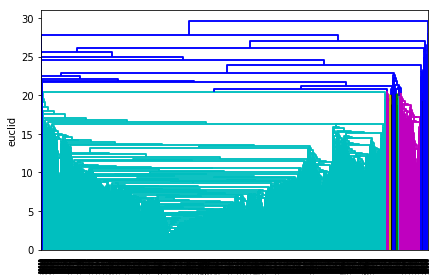

In [22]:
# 예제 10-11

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# scipy의 집괴적 군집화 함수
# 이번에는 두 클러스터에 속한 모든 샘플 간의 거리 평균을
# 클러스터를 집괴하는 기준으로 합니다.
# 거리 함수로는 유클리드 함수를 씁니다.

row_clusters = linkage(test_data, method='complete',metric='euclidean')
# 사용자 ID를 사용자 코드로 변환합니다.
tmp_label=[]
for i in range(len(id_user_dic)):
    tmp_label.append(id_user_dic[i])
    
# 플롯을 그립니다.
row_denr = dendrogram(row_clusters,labels=tmp_label)
plt.tight_layout()
plt.ylabel('euclid')
plt.show()

In [23]:
# 예제 10-13
from sklearn.cluster import AgglomerativeClustering
ward = AgglomerativeClustering(n_clusters=2, affinity='euclidean',linkage='ward')
ward.fit(test_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x104ef9ea0>)

In [25]:
# 예제 10-14
analyze_clusters_keywords_bigram(ward.labels_,product_id_name_dic,user_product_dic,id_user_dic)

Counter({0: 3351, 1: 382})
cluster_id: 0
[('RED RETROSPOT', 4117), ('T-LIGHT HOLDER', 3423), ('JUMBO BAG', 3313), ('METAL SIGN', 3303), ('LUNCH BAG', 2666), ('HOT WATER', 2535), ('WATER BOTTLE', 2535), ('SET 3', 2282), ('VINTAGE CHRISTMAS', 2127), ('CAKE CASES', 2094), ('SET 6', 1826), ('HANGING HEART', 1619), ("50'S CHRISTMAS", 1473), ('BAG VINTAGE', 1467), ('HOME SWEET', 1451), ('SWEET HOME', 1451), ('DOLLY GIRL', 1403), ('PACK 12', 1392), ('VINTAGE DOILY', 1306), ('SET 4', 1259)]
cluster_id: 1
[('RED RETROSPOT', 2361), ('JUMBO BAG', 2101), ('LUNCH BAG', 1996), ('METAL SIGN', 1531), ('CAKE CASES', 1509), ('VINTAGE CHRISTMAS', 1293), ('SET 3', 1268), ('T-LIGHT HOLDER', 1223), ('HOT WATER', 1194), ('WATER BOTTLE', 1194), ('DOLLY GIRL', 1190), ('SET 6', 1026), ('BAG VINTAGE', 978), ('VINTAGE DOILY', 939), ('SET 4', 878), ('PACK 12', 844), ("50'S CHRISTMAS", 821), ('PINK POLKADOT', 709), ('SET 12', 708), ('PANTRY DESIGN', 671)]
